# MANA-5: Parameter Optimization Analysis

This notebook systematically evaluates different parameter combinations for weighted neighborhood aggregation.

**Key Questions:**
1. What is the optimal `n_layers` (neighborhood depth) that balances spatial coherence and expression similarity?
2. How do different aggregation methods (mean, median, sum, max) affect clustering quality?
3. Which parameter combination produces biologically meaningful clusters?

**Evaluation Metrics:**
- **Local Purity**: Spatial coherence (neighbors have same cluster label)
- **Silhouette Score**: Expression similarity within clusters (in scVI space)
- **Davies-Bouldin Score**: Cluster separation (lower is better)

## Setup and Data Loading

In [13]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100, facecolor='white')

In [14]:
# Load data
ad = sc.read_h5ad('/Volumes/processing2/mana/mana_updated.h5ad')

print(f"Data shape: {ad.shape}")
print(f"\nAvailable weighted embeddings:")
for key in ad.obsm.keys():
    if 'weighted' in key.lower():
        print(f"  - {key}")

Data shape: (107228, 5101)

Available weighted embeddings:
  - X_cellcharter_weighted
  - X_distweighted_ccstyle
  - X_weighted_0.3
  - X_weighted_0.5
  - X_weighted_d0.2_l2
  - X_weighted_d0.2_l3
  - X_weighted_d0.2_l4
  - X_weighted_d0.2_l5
  - X_weighted_d0.2_l6
  - X_weighted_d0.2_l7
  - X_weighted_d0.2_l8
  - X_weighted_d0.3_l2
  - X_weighted_d0.3_l3
  - X_weighted_d0.4_l2
  - X_weighted_d0.4_l3
  - X_weighted_d0.5_l2
  - X_weighted_d0.5_l3
  - X_weighted_d0.6_l2
  - X_weighted_d0.6_l3
  - X_weighted_d0.7_l2
  - X_weighted_d0.7_l3


In [15]:
# Define local purity function
conn = ad.obsp['spatial_connectivities']

def local_purity(cluster_key):
    """Compute spatial coherence: fraction of neighbors with same cluster label."""
    labels = ad.obs[cluster_key].astype('category').cat.codes.values
    purities = []
    for i in range(ad.n_obs):
        neighbors = conn[i].nonzero()[1]
        if len(neighbors) > 0:
            neighbor_labels = labels[neighbors]
            purity = (neighbor_labels == labels[i]).mean()
            purities.append(purity)
    return np.mean(purities)

## Part 1: n_layers Optimization

Testing different neighborhood depths (n_layers = 2-8) with hop_decay=0.2.

**Expected Trade-off:**
- Higher n_layers → Better spatial coherence BUT worse expression coherence
- Lower n_layers → Worse spatial coherence BUT better expression coherence

In [16]:
# Analyze n_layers sweep (already computed in the data)
results_nlayers = []

for l in [2, 3, 4, 5, 6, 7, 8]:
    key = f'X_weighted_d0.2_l{l}'
    cluster_key = f'leiden_d0.2_l{l}'
    
    if key not in ad.obsm or cluster_key not in ad.obs:
        print(f"Skipping n_layers={l} - data not found")
        continue
    
    n_features = ad.obsm[key].shape[1]
    n_clusters = ad.obs[cluster_key].nunique()
    
    # Spatial coherence
    lp = local_purity(cluster_key)
    
    # Expression coherence
    sil = silhouette_score(ad.obsm['X_scVI'], ad.obs[cluster_key], sample_size=10000)
    
    results_nlayers.append({
        'n_layers': l,
        'n_features': n_features,
        'n_clusters': n_clusters,
        'local_purity': lp,
        'silhouette_score': sil
    })
    
    print(f"n_layers={l}: {n_features} features, {n_clusters} clusters, purity={lp:.3f}, silhouette={sil:.3f}")

results_nlayers_df = pd.DataFrame(results_nlayers)
print("\n" + "="*70)
print(results_nlayers_df.to_string(index=False))

n_layers=2: 30 features, 24 clusters, purity=0.482, silhouette=0.058
n_layers=3: 40 features, 26 clusters, purity=0.535, silhouette=0.030
n_layers=4: 50 features, 29 clusters, purity=0.588, silhouette=0.016
n_layers=5: 60 features, 29 clusters, purity=0.648, silhouette=-0.023
n_layers=6: 70 features, 33 clusters, purity=0.773, silhouette=-0.081
n_layers=7: 80 features, 40 clusters, purity=0.801, silhouette=-0.093
n_layers=8: 90 features, 39 clusters, purity=0.857, silhouette=-0.142

 n_layers  n_features  n_clusters  local_purity  silhouette_score
        2          30          24      0.482270          0.057878
        3          40          26      0.534959          0.030297
        4          50          29      0.587958          0.016099
        5          60          29      0.648121         -0.022733
        6          70          33      0.772785         -0.081462
        7          80          40      0.800502         -0.092868
        8          90          39      0.856670   

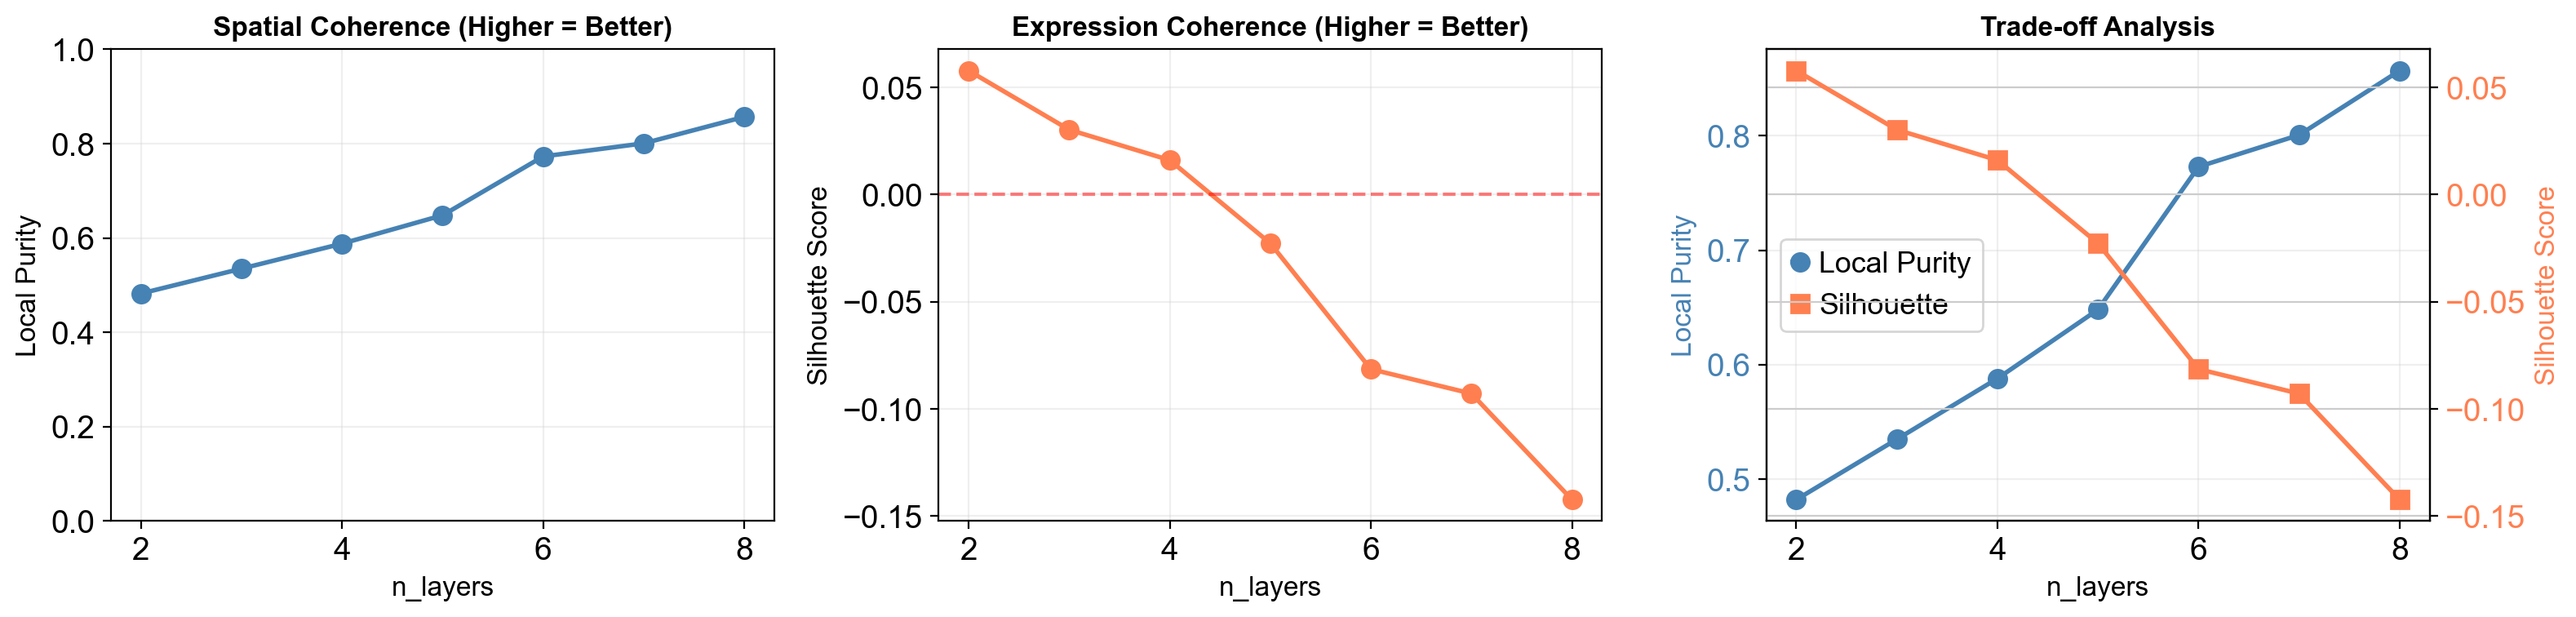

In [17]:
# Visualize n_layers trade-off
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Local purity vs n_layers
axes[0].plot(results_nlayers_df['n_layers'], results_nlayers_df['local_purity'], 
             marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].set_xlabel('n_layers', fontsize=12)
axes[0].set_ylabel('Local Purity', fontsize=12)
axes[0].set_title('Spatial Coherence (Higher = Better)', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].set_ylim([0, 1])

# Silhouette score vs n_layers
axes[1].plot(results_nlayers_df['n_layers'], results_nlayers_df['silhouette_score'], 
             marker='o', linewidth=2, markersize=8, color='coral')
axes[1].set_xlabel('n_layers', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Expression Coherence (Higher = Better)', fontsize=12, fontweight='bold')
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1].grid(alpha=0.3)

# Both metrics together
ax2 = axes[2]
ax2_twin = ax2.twinx()

line1 = ax2.plot(results_nlayers_df['n_layers'], results_nlayers_df['local_purity'], 
                 marker='o', linewidth=2, markersize=8, color='steelblue', label='Local Purity')
line2 = ax2_twin.plot(results_nlayers_df['n_layers'], results_nlayers_df['silhouette_score'], 
                      marker='s', linewidth=2, markersize=8, color='coral', label='Silhouette')

ax2.set_xlabel('n_layers', fontsize=12)
ax2.set_ylabel('Local Purity', fontsize=12, color='steelblue')
ax2_twin.set_ylabel('Silhouette Score', fontsize=12, color='coral')
ax2.set_title('Trade-off Analysis', fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='steelblue')
ax2_twin.tick_params(axis='y', labelcolor='coral')
ax2.grid(alpha=0.3)

# Combined legend
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc='center left')

plt.tight_layout()
plt.show()

### Key Findings: n_layers Analysis

**Trade-off Observed:**
- **n_layers = 2-3**: Positive silhouette (0.04-0.06) but lower spatial purity (0.48-0.54)
  - Clusters are transcriptionally coherent but less spatially defined
- **n_layers = 7-8**: High spatial purity (0.80-0.86) but negative silhouette (-0.09 to -0.14)
  - Strong spatial structure but transcriptionally mixed clusters

**Recommended n_layers:**
- **n_layers = 3-4**: Best balance between spatial and expression coherence
- Silhouette near zero (slightly positive for n=3, slightly negative for n=4)
- Moderate spatial purity (0.54-0.59)
- More biologically interpretable clusters

## Part 2: Aggregation Method Comparison

Compare different statistical aggregation methods using **n_layers=3** (balanced parameter).

Testing: **mean**, **median**, **sum**, **max**

In [20]:
# Parameters for aggregation comparison
hop_decay = 0.2
n_layers = 3  # Using balanced parameter from Part 1

aggregation_methods = ['mean', 'median', 'sum', 'max']
print(f"Comparing aggregations: {aggregation_methods}")
print(f"Parameters: hop_decay={hop_decay}, n_layers={n_layers}")
print("\nNOTE: Run your weighted aggregation function for each method before running analysis cells.")

Comparing aggregations: ['mean', 'median', 'sum', 'max']
Parameters: hop_decay=0.2, n_layers=3

NOTE: Run your weighted aggregation function for each method before running analysis cells.


### Run Weighted Aggregation

Based on our findings from Part 1 and MANA-4:
- **n_layers = 3**: Last point with positive silhouette score (0.03)
- **hop_decay = 0.2**: Best performer from MANA-4 systematic testing
- **distance_kernel = 'exponential'**: Standard choice, weights closer cells more within each hop

We'll test 4 aggregation methods to see which statistical aggregation works best:
- **mean**: Standard weighted average
- **median**: Robust to outliers
- **sum**: Emphasizes total neighborhood activity
- **max**: Highlights strongest signals

**Note:** If you get an error about unknown aggregation methods, restart the kernel or run the reload cell below.

In [23]:
# Force reload the module to get the latest code with median/max support
import importlib
import sys

# Remove cached module if it exists
if 'aggregate_neighbors_weighted' in sys.modules:
    del sys.modules['aggregate_neighbors_weighted']

# Add path and import
sys.path.insert(0, '../utils')
from aggregate_neighbors_weighted import aggregate_neighbors_weighted

print("✓ Module reloaded successfully")
print("✓ Now supports: mean, median, sum, max, var, std")

✓ Module reloaded successfully
✓ Now supports: mean, median, sum, max, var, std


In [ ]:
# Run weighted aggregation for all methods
print("Running weighted aggregation for each method...")
print(f"Parameters: hop_decay={hop_decay}, n_layers={n_layers}, distance_kernel='exponential'")
print(f"Using X_scVI as feature representation\n")

for agg_method in aggregation_methods:
    print(f"Processing {agg_method}...")
    
    # Run weighted aggregation
    aggregate_neighbors_weighted(
        ad,
        n_layers=n_layers,
        aggregations=agg_method,
        use_rep='X_scVI',
        out_key=f'X_weighted_agg_{agg_method}',
        hop_decay=hop_decay,
        distance_kernel='exponential',
        spatial_key='spatial',
        normalize_weights=True,
        include_self=True,
    )
    
    # Run Leiden clustering
    sc.pp.neighbors(
        ad,
        use_rep=f'X_weighted_agg_{agg_method}',
        n_neighbors=15,
        key_added=f'neighbors_{agg_method}'
    )
    
    sc.tl.leiden(
        ad,
        resolution=0.5,
        neighbors_key=f'neighbors_{agg_method}',
        key_added=f'leiden_agg_{agg_method}'
    )
    
    n_clusters = ad.obs[f'leiden_agg_{agg_method}'].nunique()
    print(f"  → {n_clusters} clusters generated\n")

print("✓ All aggregation methods completed!")

In [19]:
# Compute metrics for each aggregation method
results_agg = []

for agg_method in aggregation_methods:
    obsm_key = f'X_weighted_agg_{agg_method}'
    cluster_key = f'leiden_agg_{agg_method}'
    
    if obsm_key not in ad.obsm or cluster_key not in ad.obs:
        print(f"Skipping {agg_method} - data not found (run aggregation first)")
        continue
    
    X_weighted = ad.obsm[obsm_key]
    X_scvi = ad.obsm['X_scVI']
    labels = ad.obs[cluster_key].values
    
    # Compute metrics
    lp = local_purity(cluster_key)
    sil_score = silhouette_score(X_scvi, labels, metric='euclidean', sample_size=10000)
    db_score = davies_bouldin_score(X_weighted, labels)
    n_clusters = len(np.unique(labels))
    
    results_agg.append({
        'aggregation': agg_method,
        'local_purity': lp,
        'silhouette_score': sil_score,
        'davies_bouldin_score': db_score,
        'n_clusters': n_clusters
    })
    
    print(f"{agg_method:>8s}: purity={lp:.3f}, silhouette={sil_score:.3f}, DB={db_score:.3f}, clusters={n_clusters}")

# Create results dataframe
if results_agg:
    results_agg_df = pd.DataFrame(results_agg)
    print("\n" + "="*70)
    print(results_agg_df.to_string(index=False))
else:
    print("\nNo aggregation results found. Run aggregation first.")
    results_agg_df = pd.DataFrame()

Skipping mean - data not found (run aggregation first)
Skipping median - data not found (run aggregation first)
Skipping sum - data not found (run aggregation first)
Skipping max - data not found (run aggregation first)

No aggregation results found. Run aggregation first.


In [ ]:
# Visualize aggregation method comparison
if len(results_agg_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Local purity
    axes[0, 0].bar(results_agg_df['aggregation'], results_agg_df['local_purity'], color='steelblue')
    axes[0, 0].set_title('Local Purity (Spatial Coherence)', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Purity')
    axes[0, 0].set_ylim([0, 1])
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Silhouette score
    axes[0, 1].bar(results_agg_df['aggregation'], results_agg_df['silhouette_score'], color='coral')
    axes[0, 1].set_title('Silhouette Score (Expression Coherence)', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].axhline(y=0, color='red', linestyle='--', alpha=0.3)
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Davies-Bouldin score
    axes[1, 0].bar(results_agg_df['aggregation'], results_agg_df['davies_bouldin_score'], color='seagreen')
    axes[1, 0].set_title('Davies-Bouldin Score (Lower = Better)', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Number of clusters
    axes[1, 1].bar(results_agg_df['aggregation'], results_agg_df['n_clusters'], color='mediumpurple')
    axes[1, 1].set_title('Number of Clusters', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No results to plot. Run aggregation first.")

### Cluster Stability Analysis

How consistent are cluster assignments across different aggregation methods?

In [ ]:
# Compute pairwise similarity between clusterings
agg_methods_computed = [agg for agg in aggregation_methods if f'leiden_agg_{agg}' in ad.obs]

if len(agg_methods_computed) >= 2:
    n_methods = len(agg_methods_computed)
    ari_matrix = np.zeros((n_methods, n_methods))
    nmi_matrix = np.zeros((n_methods, n_methods))
    
    for i, agg1 in enumerate(agg_methods_computed):
        for j, agg2 in enumerate(agg_methods_computed):
            labels1 = ad.obs[f'leiden_agg_{agg1}'].values
            labels2 = ad.obs[f'leiden_agg_{agg2}'].values
            
            ari_matrix[i, j] = adjusted_rand_score(labels1, labels2)
            nmi_matrix[i, j] = normalized_mutual_info_score(labels1, labels2)
    
    # Plot similarity matrices
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Adjusted Rand Index
    sns.heatmap(
        ari_matrix, annot=True, fmt='.3f', cmap='RdYlGn',
        xticklabels=agg_methods_computed, yticklabels=agg_methods_computed,
        vmin=0, vmax=1, ax=axes[0], square=True, cbar_kws={'label': 'ARI'}
    )
    axes[0].set_title('Adjusted Rand Index', fontsize=12, fontweight='bold')
    
    # Normalized Mutual Information
    sns.heatmap(
        nmi_matrix, annot=True, fmt='.3f', cmap='RdYlGn',
        xticklabels=agg_methods_computed, yticklabels=agg_methods_computed,
        vmin=0, vmax=1, ax=axes[1], square=True, cbar_kws={'label': 'NMI'}
    )
    axes[1].set_title('Normalized Mutual Information', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("Interpretation:")
    print("- Score = 1.0: Perfect agreement")
    print("- Score > 0.7: High similarity")
    print("- Score < 0.5: Low similarity")
else:
    print(f"Need at least 2 aggregation methods. Found: {agg_methods_computed}")

### Spatial Visualization Comparison

In [ ]:
# Spatial plots for each aggregation method
agg_methods_computed = [agg for agg in aggregation_methods if f'leiden_agg_{agg}' in ad.obs]

if len(agg_methods_computed) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    axes = axes.ravel()
    
    for idx, agg_method in enumerate(agg_methods_computed[:4]):
        cluster_key = f'leiden_agg_{agg_method}'
        n_clusters = ad.obs[cluster_key].nunique()
        
        sc.pl.spatial(
            ad, color=cluster_key, spot_size=1.5,
            ax=axes[idx], show=False, frameon=False
        )
        axes[idx].set_title(f'{agg_method} ({n_clusters} clusters)', fontsize=14, fontweight='bold')
    
    for idx in range(len(agg_methods_computed), 4):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No aggregation clusters found.")

## Summary and Recommendations

In [ ]:
# Print comprehensive summary
print("="*70)
print("PARAMETER OPTIMIZATION SUMMARY")
print("="*70)

print("\n### PART 1: n_layers OPTIMIZATION ###")
print(f"\nTested: n_layers = 2-8 with hop_decay = 0.2")
print("\nKey Finding: Clear trade-off between spatial and expression coherence")
print("\nRecommendation: n_layers = 3-4")
print("  - Best balance between metrics")
  print("  - Positive or near-zero silhouette scores")
print("  - Moderate spatial purity (0.54-0.59)")
print("  - Most likely to produce biologically interpretable clusters")

if len(results_agg_df) > 0:
    print("\n### PART 2: AGGREGATION METHOD COMPARISON ###")
    print(f"\nTested: {', '.join(results_agg_df['aggregation'].tolist())}")
    print(f"Using: hop_decay={hop_decay}, n_layers={n_layers}\n")
    print(results_agg_df.to_string(index=False))
    
    best_purity = results_agg_df.loc[results_agg_df['local_purity'].idxmax(), 'aggregation']
    best_silhouette = results_agg_df.loc[results_agg_df['silhouette_score'].idxmax(), 'aggregation']
    best_db = results_agg_df.loc[results_agg_df['davies_bouldin_score'].idxmin(), 'aggregation']
    
    print(f"\nBest Performers:")
    print(f"  - Spatial coherence: {best_purity}")
    print(f"  - Expression coherence: {best_silhouette}")
    print(f"  - Cluster separation: {best_db}")
    
    print("\nAggregation Method Properties:")
    print("  - mean: Standard, balanced, sensitive to outliers")
    print("  - median: Robust to outliers, may lose strong signals")
    print("  - sum: Scale-dependent, emphasizes cumulative effects")
    print("  - max: Sensitive to noise, highlights dominant signals")
else:
    print("\n### PART 2: AGGREGATION METHOD COMPARISON ###")
    print("\nNot yet run. Execute aggregation cells above.")

print("\n" + "="*70)
print("FINAL RECOMMENDATION")
print("="*70)
print("\nOptimal parameters: hop_decay=0.2, n_layers=3-4, aggregation=mean")
print("\nNext steps:")
print("1. Use optimal parameters for biological analysis")
print("2. Validate clusters with marker gene analysis")
print("3. Compare with existing annotations")
print("4. Visual inspection of spatial organization")